In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
%matplotlib notebook
np.random.seed(23)

# Features as a Representation of Time Series for Classification

**version 0.2**

***
By AA Miller (Northwestern CIERA/Adler Planetarium)

10 June 2019

This lecture is about machine learning...

But honestly, this lecture isn't really about machine learning...

This lecture *is* about the classification of variable sources in astronomical survey data. There are many different ways to approach such a classification problem, and today we will use a machine leaning approach to accomplish this task.

As a(n incredibly) brief reminder, machine learning algorithms use a training set with known labels$^1$ to develop a mapping between the data and the labels. You can, and should, think of this mapping as a black box. The mapping can occur between the raw data and the labels (e.g., neural net classification of images) or between representative features$^2$ and the labels.

$^1$ Labels are the parameters of interest to be estimated (a variable star classification in this case).

$^2$Features = measured properties of the sources. 

Once the mapping between the data and the labels has been learned from the training set, new classifications can be obtained by applying the machine learning model to sources where the labels are unknown.

**Break Out Problem 1**

Why would it be useful to measure features from astronomical light curves in order to classify them in an automated fashion?

**Solution to Break Out 1**

*Write your answer here*

The peculiarities of astronomical light curves (observational gaps, heteroskedastic uncertainties, etc) makes it difficult to compare any 2 random sources. For example, the cadence of observations in one portion of the sky will ultimately be very different from any other point on the sky separated by an appreciable distance ($\sim 100^\circ$ for LSST). 

The use of features allows us to place all sources on the same basis. In this way it then becomes possible to make 1 to 1 comparisons between sources with different observing sequences.

## Problem 1) The ML Training Set

Here we are going to define some helper functions that you may find helpful in your efforts to build this variable star classification model.

These functions include `lc_plot`, which will produce a nice plot of the light curve showing the full duration of the observations as well as a phase folded light curve.

And `read_lc`, which can quickly read the data format provided for the light curves.

In [2]:
def lc_plot(t, m, m_unc, period=0.0):
    if period == 0.0:
        fig, ax = plt.subplots()
        ax.errorbar(t, m, m_unc, 
                    fmt='o', color='MediumAquaMarine',
                    mec="0.2",mew=0.5)
        ax.set_xlabel('HJD (d)')
        ax.set_ylabel(r'$V_\mathrm{ASAS}\;(\mathrm{mag})$')
        fig.gca().invert_yaxis()
    elif period != 0.0:
        fig = plt.figure()
        gs = GridSpec.GridSpec(5, 1)
        ax_full = plt.subplot(gs[:2, :])
        ax_full.errorbar(t, m, m_unc, 
                         fmt='o', color='MediumAquaMarine',
                         mec="0.2",mew=0.5)
        ax_full.set_xlabel('HJD (d)')
        ax_full.set_ylabel(r'$V_\mathrm{ASAS}\;(\mathrm{mag})$')
        plt.gca().invert_yaxis()

        ax_phase = plt.subplot(gs[2:, :])
        for repeat in [-1, 0, 1]:
            ax_phase.errorbar(t/period % 1 + repeat, m, m_unc, 
                             fmt='o', color='MediumAquaMarine',
                             mec="0.2",mew=0.5)
        ax_phase.axvline(x=0, ls='--', color='0.8', lw=1, zorder=3)
        ax_phase.axvline(x=1, ls='--', color='0.8', lw=1, zorder=3)
        ax_phase.set_xlim(-0.2, 1.2)
        ax_phase.set_xlabel('Phase')
        ax_phase.set_ylabel(r'$V_\mathrm{ASAS}\;(\mathrm{mag})$')
        plt.gca().invert_yaxis()
    
    plt.tight_layout()

In [3]:
def read_lc(filename):
    hjd, mag, mag_unc = np.loadtxt(filename, unpack=True)
    return hjd, mag, mag_unc

If you did not already have the training set, download and unpack the [tarball](https://northwestern.box.com/s/o6knkdzvabk9tc3u0diizpqrhhae70xq).

We will be working with data from the [ASAS survey](http://www.astrouw.edu.pl/asas/), and I have already curated a training set that only includes stars in 1 of 7 classes: Mira variables, RR Lyrae stars, detatched eclipsing binaries, semi-detatched eclipsing binaries, W UMa binaries, Cepheids, and R Cor Bor stars. 

[If you don't know what any of these things are, don't worry, we have examples below.]

**Problem 1a**

Plot an example Mira light curve.

*Hint* - just execute the cell.

<IPython.core.display.Javascript object>


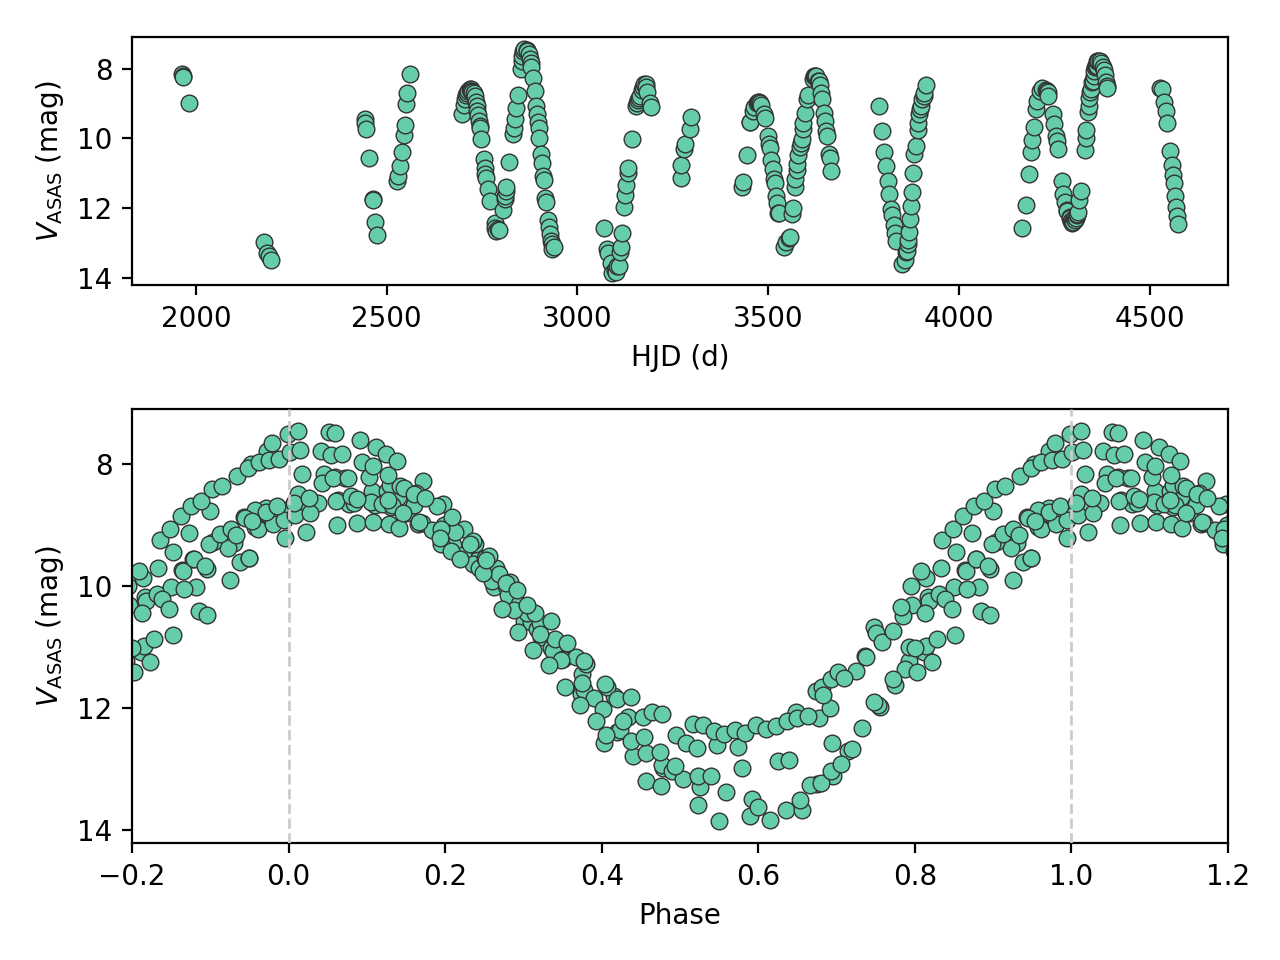

In [4]:
# Mira example
t, m, m_unc = read_lc("./training_lcs/181637+0341.6")
lc_plot(t, m, m_unc, period=150.461188)

**Problem 1b**

Plot an example RR Lyrae light curve.

<IPython.core.display.Javascript object>


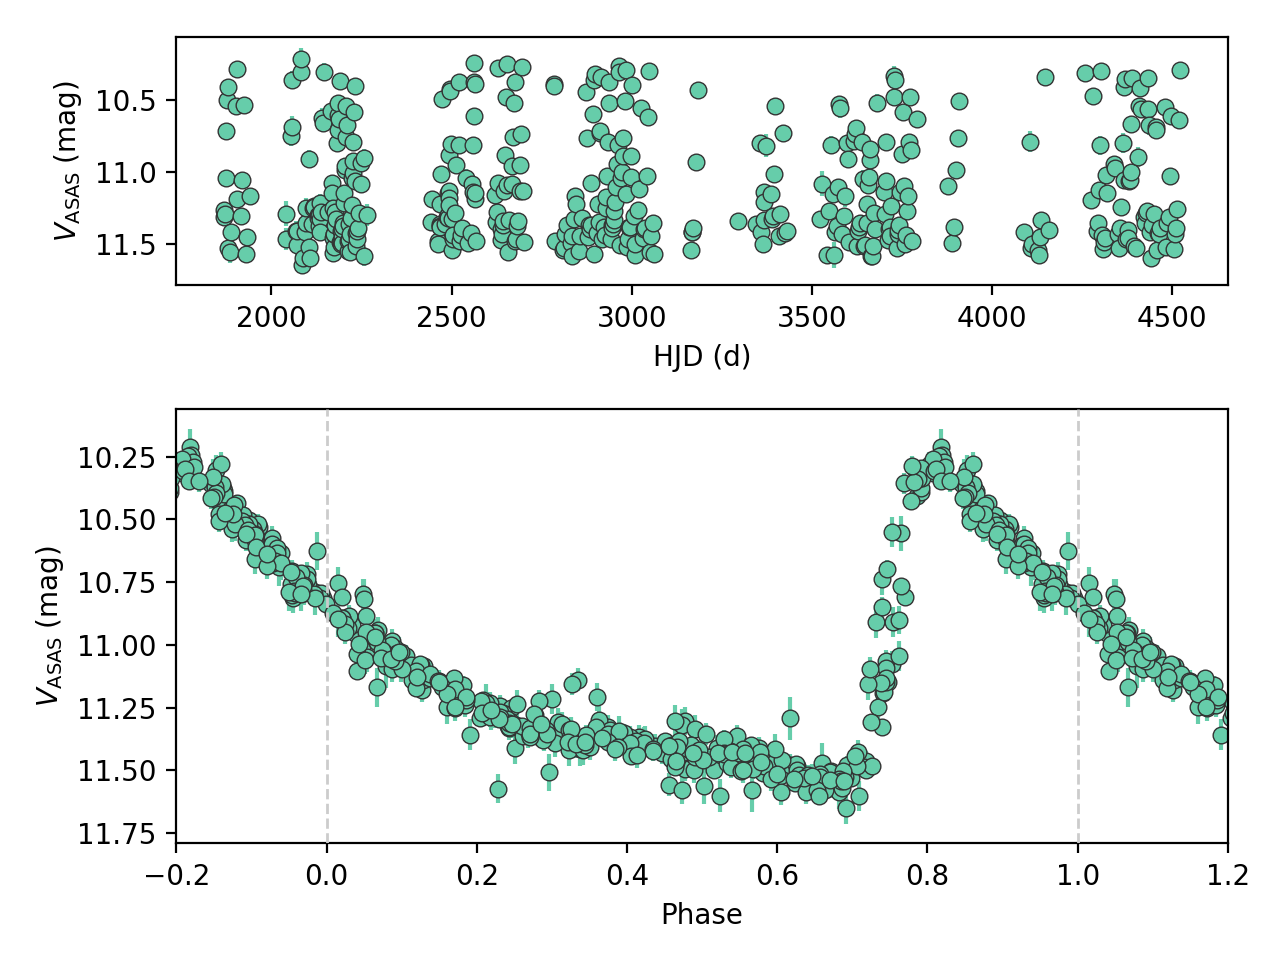

In [5]:
# RRL example
t, m, m_unc = read_lc("./training_lcs/011815-3912.8")
lc_plot(t, m, m_unc, period=0.510918)

**Problem 1c**

Plot an example detatched eclipsing binary (EB) light curve.

<IPython.core.display.Javascript object>


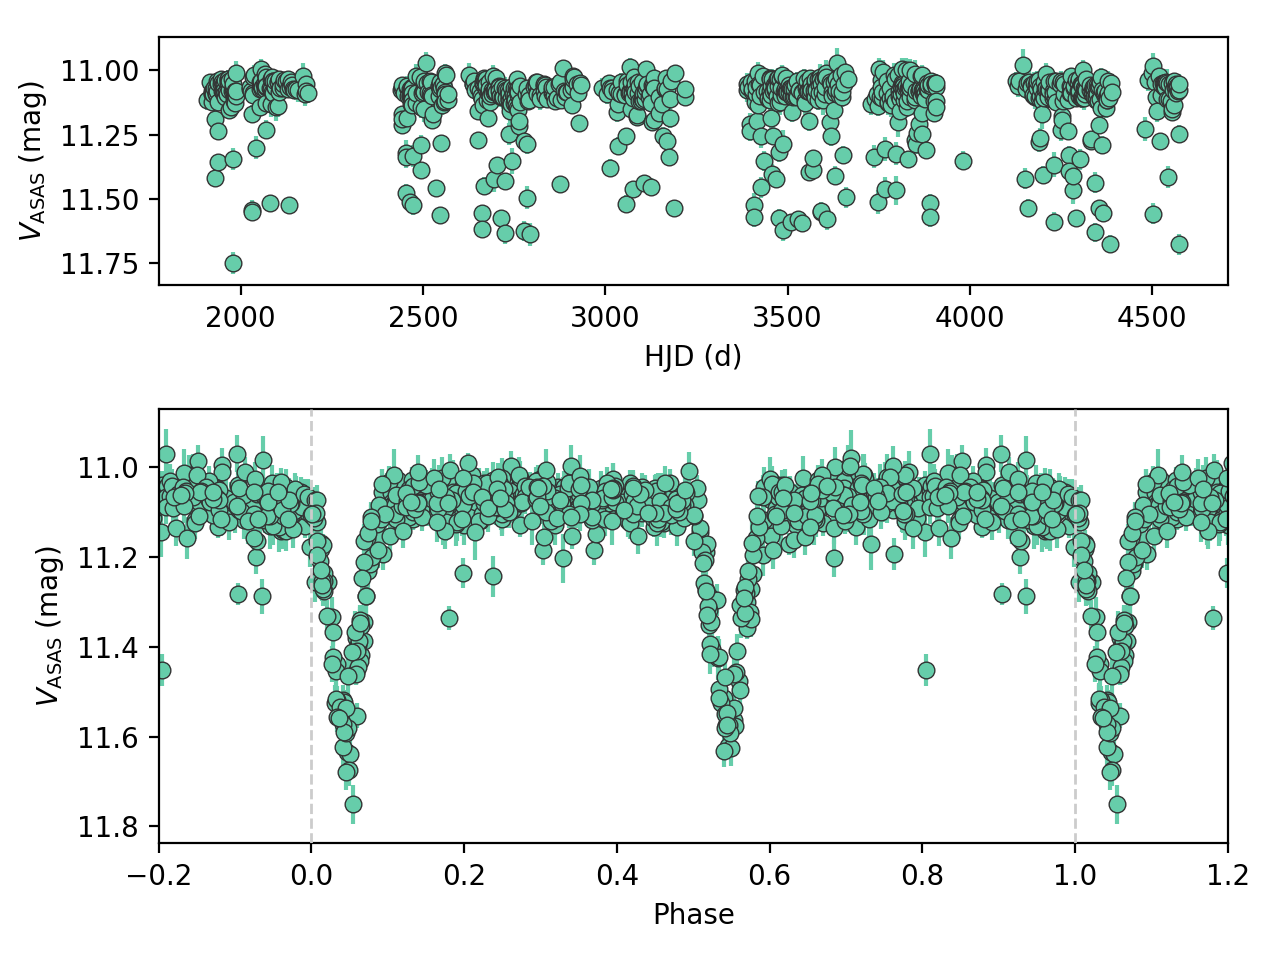

In [6]:
# dEB example
t, m, m_unc = read_lc("./training_lcs/153835-6727.8")
lc_plot(t, m, m_unc, period=2*1.107174)

**Problem 1d**

Plot an example semi-detatched EB light curve.

<IPython.core.display.Javascript object>


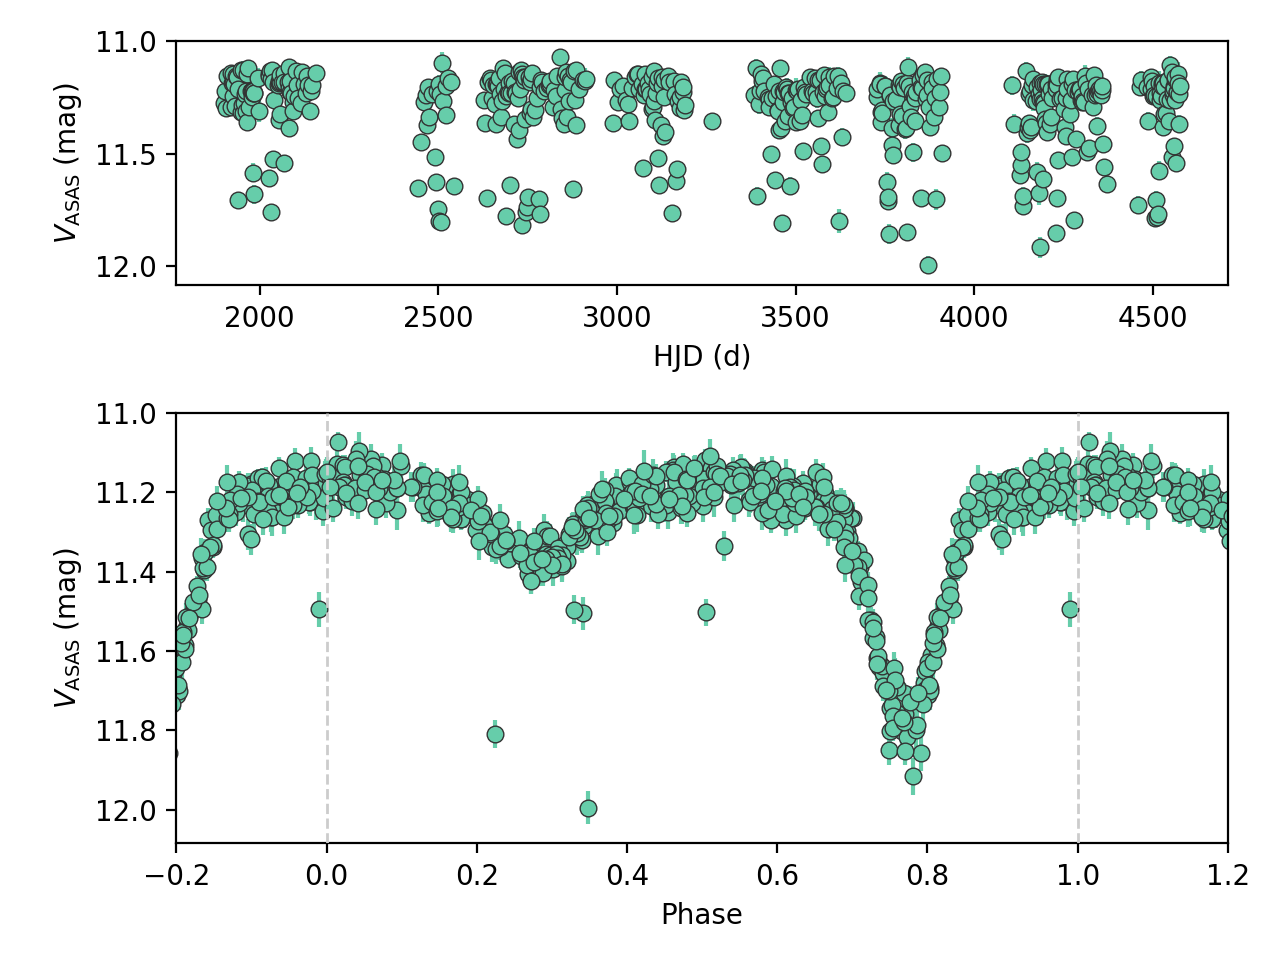

In [7]:
# aEB example
t, m, m_unc = read_lc("./training_lcs/141748-5311.2")
lc_plot(t, m, m_unc, period=1.514158)

**Problem 1e**

Plot an example W UMa EB light curve.

<IPython.core.display.Javascript object>


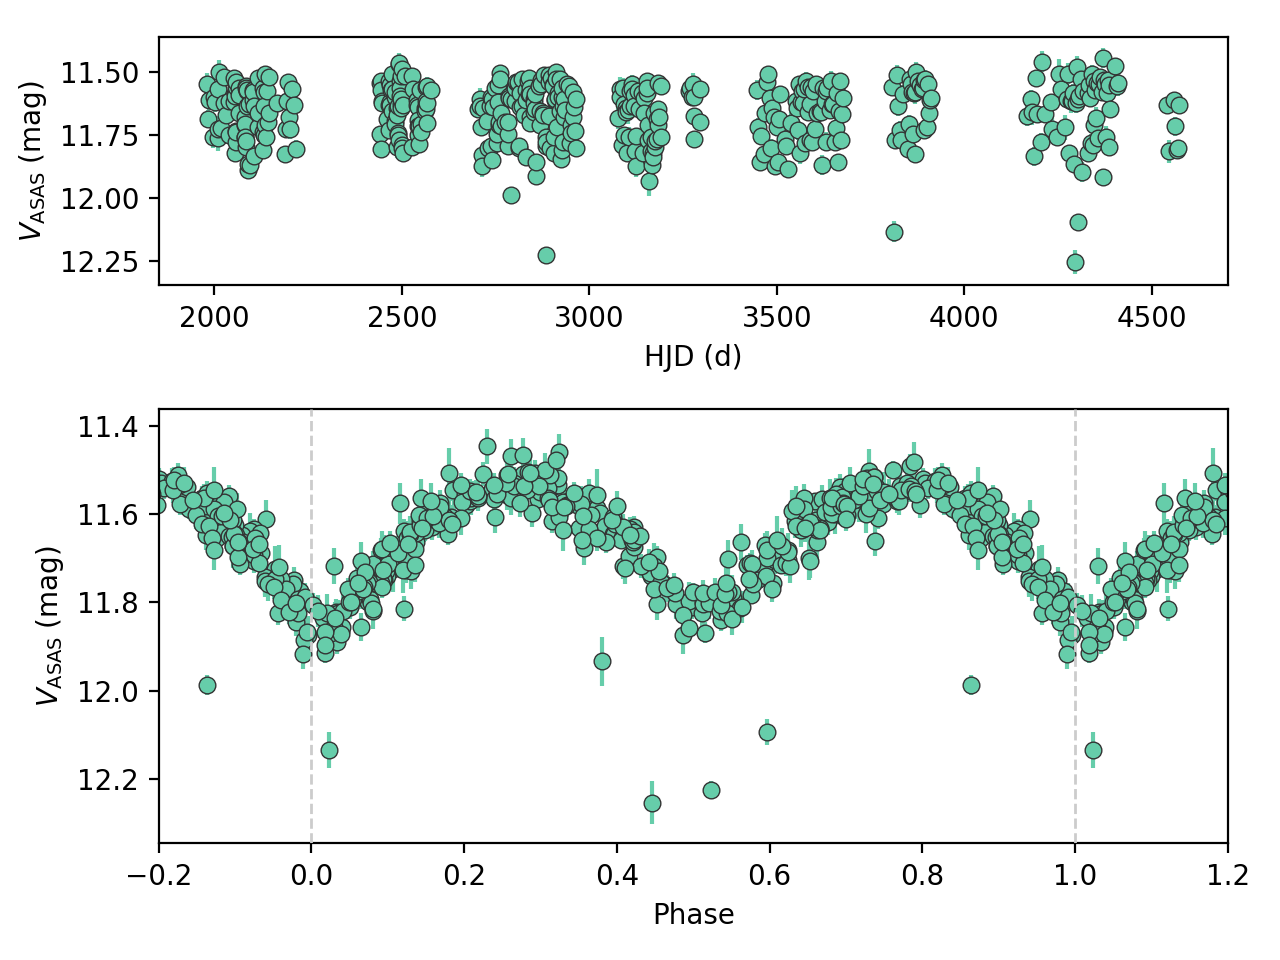

In [8]:
# WU example
t, m, m_unc = read_lc("./training_lcs/193546-1136.3")
lc_plot(t, m, m_unc, period=0.424015)

**Problem 1f**

Plot an example Cepheid light curve.

<IPython.core.display.Javascript object>


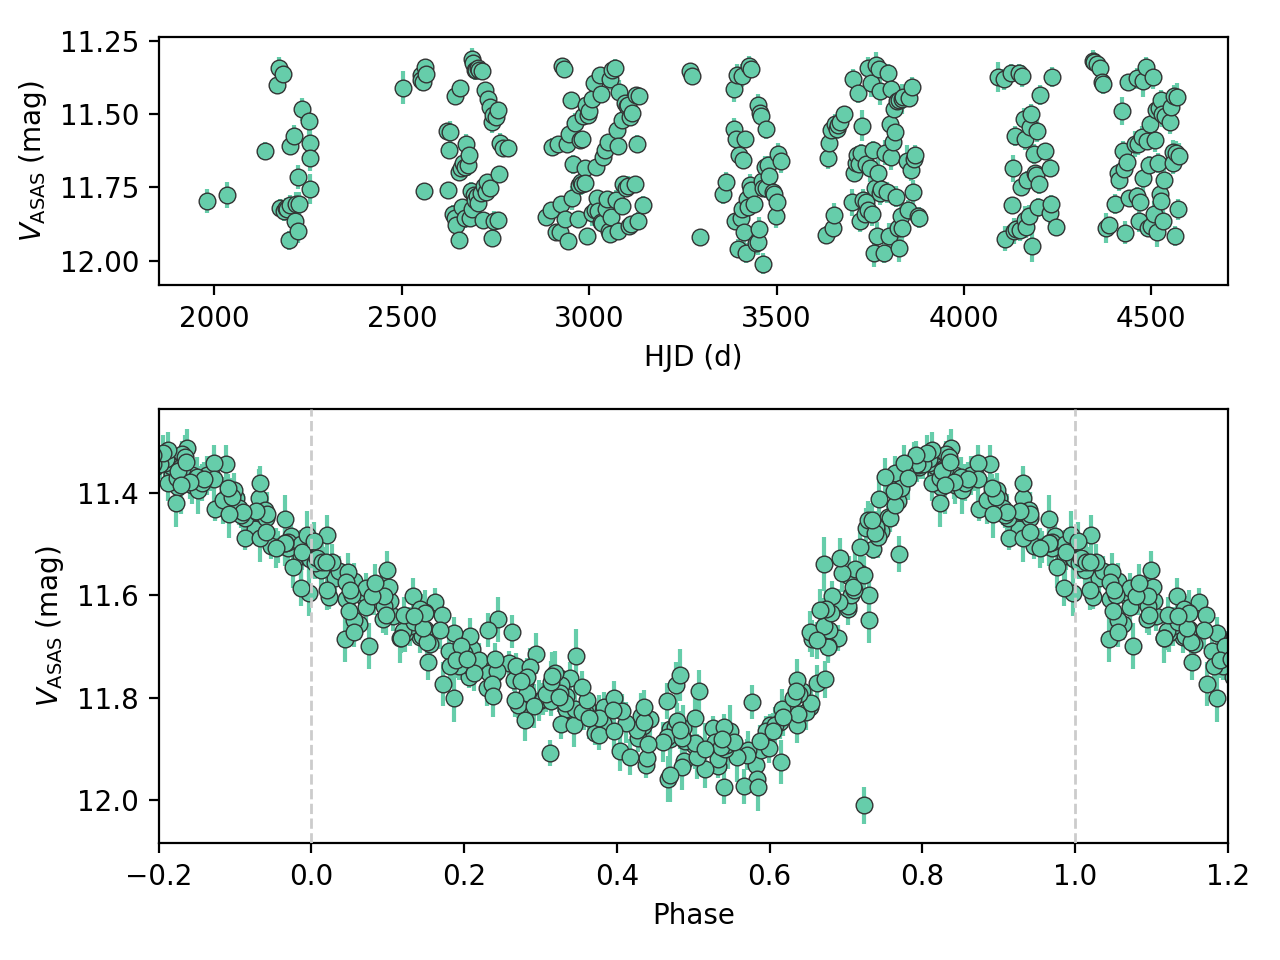

In [9]:
# Cepheid example
t, m, m_unc = read_lc("./training_lcs/065640+0011.4")
lc_plot(t, m, m_unc, period=4.022837)

**Problem 1g**

Plot an example R Cor Bor star light curve.

<IPython.core.display.Javascript object>


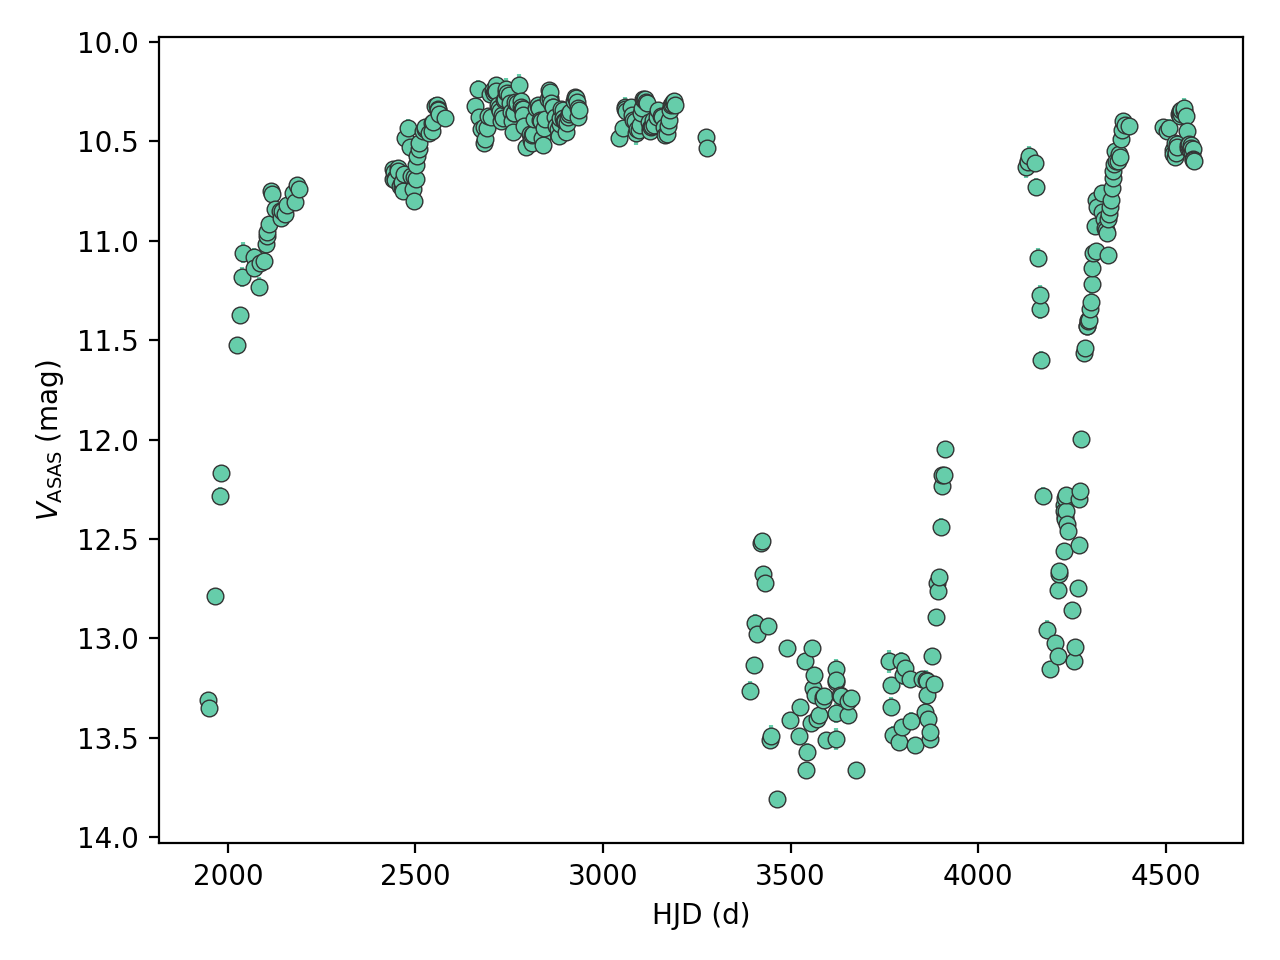

In [10]:
# R Cor Bor example
t, m, m_unc = read_lc("./training_lcs/163242-5315.6")
lc_plot(t, m, m_unc, period=0.0)

## Problem 2) Machine Learning Classification

To classify newly observed light curves we need a machine learning model.

Previously I said this is not a machine learning problem, and that is because we will all use the same pre-specified model. I have provided a file `training_sources.csv` which includes the name of the sources, along with some features, and their classification.

**Problem 2a**

Read in the training set file, and create a feature vector `X` and label array `y`.

In [11]:
train_df = pd.read_csv("training_sources.csv")

X_train = np.array(train_df[["mean", "nobs", "duration"]])
y_train = np.array(train_df["Class"])

The provided training set comes with 3 features: i) the mean magnitude of the observations, ii) the total number of observations obtained, and iii) the duration of the observations.

**Problem 2b**

Using the helper function provided below, calculate the 10-fold cross-validation accuracy of a random forest machine learning model using the 3 features provided above.

*Note* - do not adjust any part of `calc_cv_score` throughout this exercise.

In [12]:
def calc_cv_score(X, y):
    rf_clf = RandomForestClassifier(n_estimators=150, min_samples_leaf=1)
    
    cv_score = cross_val_score(rf_clf, X, y, cv=10, n_jobs=-1)
    
    print("These features have CV accuracy = {:.4f} +/- {:.4f}".format(np.mean(cv_score), np.std(cv_score, ddof=1)))

calc_cv_score(X_train, y_train)

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


These features have CV accuracy = 0.4558 +/- 0.0442


## Problem 3) Feature Engineering

It should now be clear why this is not a machine learning problem. We have, in this case, provided all the machine learning code that you will need.

Instead, this is a feature engineering problem. Feature engineering requires the utilization of domain knowledge to create new features for a data set to improve the performance of machine learning algorithms.

Add new features - if necessary
  - Utilize domain knowledge to create/compute new features
  - Combine features or represent them in an alternative fashion

Remove noisy/uniformative features - if necessary
  - Determine feature importance (RF)
  - Forward/backward selection to iteratively remove features

Below I have provided a partial function `calc_feature` which you can alter to calculate new features for the data set. 

In [13]:
def calc_feature(df, train=True):
    
    if train==True:
        lc_dir = "./training_lcs/"
    else:
        lc_dir = "./test_lcs/"
    
    feature = np.empty(len(df))
    for source_num, asas_id in enumerate(df["ASAS_ID"]):
        t, m, mu = read_lc(lc_dir+asas_id)
        # feature calculations
        # feature calculations
        # feature calculations
        
        feature[source_num] = feat_val
    
    return feature

Your objective now is to apply your domain knowledge of astronomical signals to improve the provided machine learning model via feature engineering (and only feature engineering - do not attempt to use other models or change the model parameters).

Below are 3 problems you should attempt to answer, but note - these problems are not necessarily independent and do not need to be completed sequentially.

**With a partner answer the following:**

**Problem 3a**

What is the best *simple* feature you can add to the model to improve the classification performance? 

Why simple? Because speed matters. If you need to classify $10^7$ LSST sources, you cannot run models that take several minutes to hours to run...

*Note* - simple means can be executed on the full training set in a matter of seconds ($\lesssim 100\,\mathrm{s}$).

**Problem 3b**

What is the best individual feature you can add to the model to improve the classification performance? 

**Problem 3c**

What combination of features provides the best classification accuracy for the model?

*Hint 1* - use `calc_cv_score` to measure the classification performance.

*Hint 2* - if your efforts are limited by file read times, consider calculating multiple features within the function `calc_feature`.

*Hint 3* - you are in pairs for a reason. If you decide to attempt a very complicated feature that requires long runtimes, proceed with that calculation on one person's laptop, while working on some other feature calculation on the other person's laptop.

*Hint 4* - be very careful about book keeping and variable names. You don't want to have to repeat a complex calculation because you accidentally renamed an active variable in your namespace.

*Hint 5* - do not destroy any code that you write to calculate features. Ultimately, you will need to apply your feature calculations to a test set of new sources and it will be essential that the calculations are done in a reproducible way.

*Hint 6* - pay attention to how long it takes for your feature calculations to run. If you have anything that takes $\gtrsim 30\,\mathrm{min}$ let me know immediately.

We will compare answers at the end of the lecture.

## Problem 4) Testing the Model on Independent Light Curves

You can load the test set using the commands below.

In [14]:
test_df = pd.read_csv("test_sources.csv")

X_test = np.array(test_df[["mean", "nobs", "duration"]])
y_test = np.array(test_df["Class"])

After you have read that data you *must* calculate features on the test set using exactly the same method that you employed for the training set. 

*Note* - if you created a new `calc_feature` script for every feature that you calculated, this should be straightforward.

In [ ]:
### Calculate features for the test set here

**Problem 4a**

Calculate the accuracy of your model via an analysis of the independent test set. A helper function has been provided for you to do this below.

In [21]:
from sklearn.metrics import accuracy_score
def calc_model_acc(X_train, y_train, X_test, y_test):
    '''
    Parameters
    ----------
    
    X_train - arr_like, (n_source, n_feat) shape
        Feature set for the training set. A 2D array 
        containing one row for every source, and one 
        column for every feature in the training set.
    y_train - arr_like, (n_source,) shape
        Labels for the training set, with one label 
        per source.
    X_test - arr_like, (n_source, n_feat) shape
        Feature set for the test set. A 2D array 
        containing one row for every source, and one 
        column for every feature in the training set.
    y_test - arr_like, (n_source,) shape
        Labels for the test set, with one label 
        per source.

    '''
    rf_clf = RandomForestClassifier(n_estimators=150, min_samples_leaf=1)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Your model accuracy is: {:.2f}".format(accuracy*100))

In [23]:
# model accuracy for the provided features
calc_model_acc(np.array(train_df[["mean", "nobs", "duration"]]), y_train, 
               np.array(test_df[["mean", "nobs", "duration"]]), y_test)

Your model accuracy is: 45.77


Now we buld a model using the scatter (standard deviation) as a "simple" feature (see **3a**).

In [26]:
def calc_scatter(df, train=True):
    
    if train==True:
        lc_dir = "./training_lcs/"
    else:
        lc_dir = "./test_lcs/"
    
    feature = np.empty(len(df))
    for source_num, asas_id in enumerate(df["ASAS_ID"]):
        t, m, mu = read_lc(lc_dir+asas_id)
        feat_val = np.std(m, ddof=1)
        
        feature[source_num] = feat_val
    
    return feature

train_scatter = calc_scatter(train_df)
test_scatter = calc_scatter(test_df, train=False)

train_df["scatter"] = train_scatter
test_df["scatter"] = test_scatter

calc_model_acc(np.array(train_df[["mean", "nobs", "duration", "scatter"]]), y_train, 
               np.array(test_df[["mean", "nobs", "duration", "scatter"]]), y_test)

Your model accuracy is: 73.19


Now we build a model to measure the LS frequency as a *complicated* feature. (See **3b**)

In [27]:
from astropy.stats import LombScargle

def calc_ls_freq(df, train=True):
    
    if train==True:
        lc_dir = "./training_lcs/"
    else:
        lc_dir = "./test_lcs/"
    
    feature = np.empty(len(df))
    for source_num, asas_id in enumerate(df["ASAS_ID"]):
        t, m, mu = read_lc(lc_dir+asas_id)
        freq, power = LombScargle(t, m, mu).autopower(maximum_frequency=5)
        
        feat_val = freq[np.argmax(power)]
        
        feature[source_num] = feat_val
    
    return feature

train_freq = calc_ls_freq(train_df)
test_freq = calc_ls_freq(test_df, train=False)

train_df["ls_freq"] = train_freq
test_df["ls_freq"] = test_freq

calc_model_acc(np.array(train_df[["mean", "nobs", "duration", "ls_freq"]]), y_train, 
               np.array(test_df[["mean", "nobs", "duration", "ls_freq"]]), y_test)

Your model accuracy is: 85.91


Now we test a model that includes the mean, median, amplitude, standard deviation, and best fit period for the data. (See **4c**)

In [47]:
feat_list = ["mean", "ls_freq", "median", "amplitude", "scatter"]
calc_model_acc(np.array(train_df[feat_list]), y_train, 
               np.array(test_df[feat_list]), y_test)

Your model accuracy is: 89.20


What if we use all the features included in a great$^\dagger$ paper that classified all the variable sources in ASAS ([Richards et al. 2012](http://adsabs.harvard.edu/abs/2012ApJS..203...32R)). Note - this calculation takes a while and is not reproduced here.

$^\dagger$ This paper may actually be great. I'm a coauthor, so I'm biased.

In [43]:
cs_train_df = pd.read_csv("train_cs.csv")
cs_test_df = pd.read_csv("test_cs.csv")

X_train_cs = np.array(cs_train_df)
X_test_cs = np.array(cs_test_df)

calc_model_acc(X_train_cs, y_train, 
               X_test_cs, y_test)

Your model accuracy is: 98.99


Some extra feature calculations are included below.

In [24]:
def calc_median(df, train=True):
    
    if train==True:
        lc_dir = "./training_lcs/"
    else:
        lc_dir = "./test_lcs/"
    
    feature = np.empty(len(df))
    for source_num, asas_id in enumerate(df["ASAS_ID"]):
        t, m, mu = read_lc(lc_dir+asas_id)
        feat_val = np.median(m)
        
        feature[source_num] = feat_val
    
    return feature

train_median = calc_median(train_df)
test_median = calc_median(test_df, train=False)

train_df["median"] = train_median
test_df["median"] = test_median

calc_model_acc(np.array(train_df[["mean", "nobs", "duration", "median"]]), y_train, 
               np.array(test_df[["mean", "nobs", "duration", "median"]]), y_test)

Your model accuracy is: 50.48


In [25]:
def calc_amp(df, train=True):
    
    if train==True:
        lc_dir = "./training_lcs/"
    else:
        lc_dir = "./test_lcs/"
    
    feature = np.empty(len(df))
    for source_num, asas_id in enumerate(df["ASAS_ID"]):
        t, m, mu = read_lc(lc_dir+asas_id)
        feat_val = np.ptp(m)
        
        feature[source_num] = feat_val
    
    return feature

train_amp = calc_amp(train_df)
test_amp = calc_amp(test_df, train=False)

train_df["amplitude"] = train_amp
test_df["amplitude"] = test_amp

calc_model_acc(np.array(train_df[["mean", "nobs", "duration", "amplitude"]]), y_train, 
               np.array(test_df[["mean", "nobs", "duration", "amplitude"]]), y_test)

Your model accuracy is: 61.68
